In [275]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import sklearn.metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [345]:
df = pd.read_excel("base_a_traiter.xlsx")
df = df[df["Compagnie"] != "SNCF"]
df["Month"] = df["Date_aller"].apply(lambda date:date.month)  # On crée de nouvelles variables qui feront partie des variabls explicatives des modèles de régression
df["Week"] = df["Date_aller"].apply(lambda date:date.week)
n = int(0.4*len(df.sort_values("Prix")))       # On ne prend pas en compte les valeurs de prix extrêmes qui peuvent biaiser nos prédictions
df = df.sort_values("Prix").iloc[:n]

# Preprocessing

<ipython-input-346-2fc886fee4d9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg["y_standard"] = preprocessing.scale(df_reg["Prix"]) # On transforme la variable "Prix" de sorte à ce que sa loi soit la loi normale centrée réduite


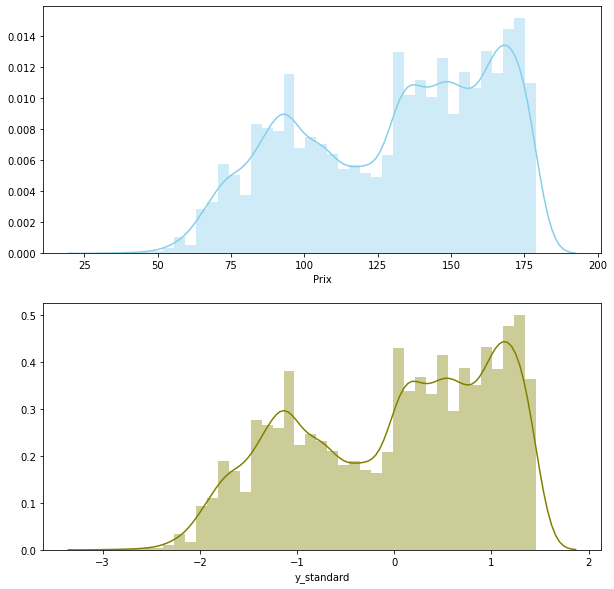

In [346]:
from sklearn import preprocessing
xvars = ["Distance", "Total d'escales", "Duree de vol", "Month", "Week", "Compagnie"] # Variables explicatives
df_reg = df[["Prix"] + xvars]
df_reg["y_standard"] = preprocessing.scale(df_reg["Prix"]) # On transforme la variable "Prix" de sorte à ce que sa loi soit la loi normale centrée réduite
df_reg.dropna(how = "any")
f, axes = plt.subplots(2, figsize=(10, 10))
sns.distplot(df_reg["Prix"] , color="skyblue", ax=axes[0])
sns.distplot(df_reg["y_standard"] , color="olive", ax=axes[1]) # On vérifie que la distribution de la variable "y_standard" est centrée et que sa variance empirique vaut 1

In [347]:
df_regb = df[xvars].drop(columns = ["Compagnie", "Week", "Month"]) # On conserve les variables quantitatives
indices_to_keep = ~df_regb.isin([np.inf, -np.inf]).any(axis = 1)
df_regb = df_regb[indices_to_keep].astype(np.float64)
scaler = preprocessing.StandardScaler().fit(df_regb) 
X1 = scaler.transform(df_regb) # On applique le Transformer Scaler qui transforme nos données empiriques de sorte à ce que leur moyenne vaille 0 et leur variance vaille 1

In [348]:
X2 = pd.get_dummies(df["Compagnie"]) # On transforme la variable "Compagnie" en variables indicatrices pour chaque compagnie de vol
X2 = np.array(X2)
X = np.concatenate((X1,X2), axis=1)

In [349]:
X3 = pd.get_dummies(df["Week"]) 
X3 = np.array(X3)
X = np.concatenate((X, X3), axis = 1)

In [350]:
X4 = pd.get_dummies(df["Month"])
X4 = np.array(X4)
X = np.concatenate((X, X4), axis = 1)

# Régression linéaire

In [351]:
X_train, X_test, y_train, y_test = train_test_split(X, df_reg[["y_standard"]].values.ravel(), test_size = 0.3, random_state = 0) # On répartit nos données en base d’apprentissage et de test
ols = LinearRegression().fit(X_train, y_train) # On applique le modèle de régression linéaire aux données standardisées
y_pred = ols.predict(X_test)
print(ols.intercept_, ols.coef_)

-184479153693.86652 [ 2.02081383e-01  3.81352618e-01 -1.19176713e-01 -2.73692815e-01
 -3.92941802e-01 -4.07989527e-01 -1.06322313e+00 -3.05213305e-01
 -6.46535882e-01 -6.10614789e-01 -1.18955970e+00 -1.28976917e+00
 -5.20575429e-01 -8.71788104e-01 -6.70834276e-01 -3.70166719e-01
 -1.28014248e+00 -1.22824365e+00 -9.28432914e-01 -9.15935657e-01
 -1.18608391e+00 -7.40704572e-01 -3.26758197e-01 -9.50652129e-01
 -1.96210992e+00 -4.49982046e-01 -1.05297166e+00 -8.44340604e-01
 -1.96509997e+00 -1.54974290e+00 -6.38553684e-01 -1.26719015e+00
 -1.02307002e+00 -4.85179399e-01 -1.60504991e+00  1.85087510e+11
  1.85087510e+11  1.85087510e+11  1.85087510e+11  1.85087510e+11
 -3.25833225e+11 -3.25833225e+11 -3.25833225e+11 -3.25833225e+11
  3.99316013e+10  3.99316013e+10  3.99316013e+10  3.99316013e+10
  9.68729017e+10  9.68729017e+10  9.68729017e+10  9.68729017e+10
  9.68729017e+10  1.42063752e+10  1.42063752e+10  1.42063752e+10
  1.42063752e+10 -1.18440260e+11 -1.18440260e+11 -1.18440260e+11
 -1.1

In [355]:
mse = sklearn.metrics.mean_squared_error(y_test, y_pred, squared = False)
r = sklearn.metrics.r2_score(y_test, y_pred)
print("Mean squared error: %.2f" % mse)
print("Coefficient of Pearson's linear determination: %.2f" % r)

Mean squared error: 0.76
Coefficient of Pearson's linear determination: 0.42


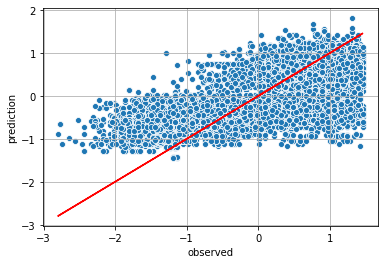

In [354]:
fig = plt.figure()
axes = plt.axes()
axes.grid()
tempdf = pd.DataFrame({"prediction": y_pred, "observed": y_test, "error": y_test - y_pred})
sns.scatterplot(data = tempdf, x = "observed", y = "prediction")
plt.plot(y_test,y_test,'r') # On regarde la concentration des prédictions autout de la première bissectrice
# Plus le coefficient de détermination linéaire de Pearson sera proche de 1 et plus les points seront concentrées autour de la droite

# Régression Logistique



In [356]:
df_reg['y'] = (df_reg["y_standard"] > 0.5).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, df_reg[["y"]].values.ravel(), test_size = 0.2, random_state = 0)
clf = LogisticRegression().fit(X_train, y_train) # On applique lemodèle de régression logistique aux données standardisées
y_pred = clf.predict(X_test)
print(clf.intercept_, clf.coef_)

<ipython-input-356-fb05a60e89a9>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reg['y'] = (df_reg["y_standard"] > 0.5).astype(int)


[0.22774139] [[ 0.32700752  0.87443388 -0.38693306  1.72544868  0.51042901  0.73791728
  -0.47878169  0.80359311  1.18911337  1.10200525 -1.25989265 -1.63864169
   1.32376329  0.02213569  1.72107085  0.79363638 -1.24529402 -0.77971459
  -0.62961001 -0.65535439 -1.46739122  0.26452532  1.59810829 -0.42420376
  -2.50040518  1.00628227 -0.92986173 -0.25911509 -2.40156148 -1.3898376
   2.8932011   0.05057831 -0.51592862  1.25452881 -1.4210081   1.26480706
  -2.29211118 -0.03192053  0.09931058  0.56491147  0.18653934 -0.2659492
  -0.27217467  0.01334522 -0.13751585 -0.1471998  -0.11194284  0.2136352
  -0.36354976  0.27187108 -0.00430501  0.16159569  0.35962824  0.26759817
  -0.08322483  0.03674321  0.2016683   0.52877413 -0.13097908  0.09175786
  -0.25684828 -0.39500261 -0.33823931 -0.18302328  0.42524024  0.42278485
   0.23270463]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7376769571891523
0.6387975575387506
0.6872157655381506
0.596752961825362


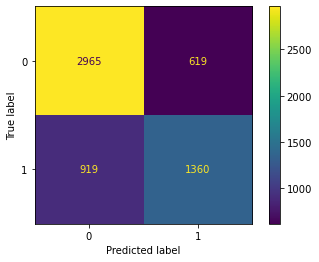

In [357]:
sklearn.metrics.plot_confusion_matrix(clf, X_test, y_test) # On affiche la matrice de confusion du modèle

sc_accuracy = sklearn.metrics.accuracy_score(y_pred, y_test)
sc_f1 = sklearn.metrics.f1_score(y_pred, y_test)
sc_recall = sklearn.metrics.recall_score(y_pred, y_test)
sc_precision = sklearn.metrics.precision_score(y_pred, y_test)

print(sc_accuracy) # On affiche une mesure de la qualité de prédiction du modèle 
print(sc_f1)
print(sc_recall)
print(sc_precision)